# Big Data Analytics - Final Project

Group Number: 7



Somia Abdelrahman| Thomas Archibald| Rajat Chelani | Immanuel Odarteifio

### Setting up our Spark environment
The next cell installs PySpark in the Google Colab environment. Spark is written in Scala and runs in a Java Virtual Machine. PySpark is a Python interface to a Spark backend virtual machine (VM). There are Java, Python, R, Scala and SQL frontend interfaces to Spark. Essentially, PySpark sends the Python Spark commands to the Spark VM for evaluation, then the results are returned to the PySpark frontend.

In [1]:
# Do not change or modify this cell
# Need to install pyspark
# if pyspark is already installed, will print a message indicating requirement already satisfied
! pip install pyspark >& /dev/null

In [2]:
# Create Spark Session and Spark Context
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('BDA-final-project').getOrCreate()
sc = spark.sparkContext

In [3]:
# your code here

#Import packages
from pyspark.sql.types import StructType, StructField, IntegerType, TimestampType, StringType, DoubleType, FloatType
from pyspark.sql import functions as f

#Read to spark dataframe
diagnosis = spark.read.csv('training.csv', header = True, inferSchema = True)

#View & print the total count
print('There are', diagnosis.count(), 'records in the data set.')
diagnosis.show()

There are 12906 records in the data set.
+----------+------------+------------------+-------------+------------+-----------+--------------+-----+----------------------------+----------------------------+--------------------------------+--------------------------------+-------------------------------------+---------+------------------+-----------+-----------+-----------+------------+------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-------------+-----------+-----------+------------------+-----------------------+------------------------+------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+--------------------------+---------------------------+-------------------------+---------------------------+------------------------+--------------+-------------+-----------+--------

In [4]:
diagnosis.printSchema()

#calc the total numbers of columns and rows
row = diagnosis.count()
col = len(diagnosis.columns)

#Print the results
print(f'Number of Rows are: {row}')
print(f'Number of Columns are: {col}')

root
 |-- patient_id: integer (nullable = true)
 |-- patient_race: string (nullable = true)
 |-- payer_type: string (nullable = true)
 |-- patient_state: string (nullable = true)
 |-- patient_zip3: integer (nullable = true)
 |-- patient_age: integer (nullable = true)
 |-- patient_gender: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- breast_cancer_diagnosis_code: string (nullable = true)
 |-- breast_cancer_diagnosis_desc: string (nullable = true)
 |-- metastatic_cancer_diagnosis_code: string (nullable = true)
 |-- metastatic_first_novel_treatment: string (nullable = true)
 |-- metastatic_first_novel_treatment_type: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Division: string (nullable = true)
 |-- population: double (nullable = true)
 |-- density: double (nullable = true)
 |-- age_median: double (nullable = true)
 |-- age_under_10: double (nullable = true)
 |-- age_10_to_19: double (nullable = true)
 |-- age_20s: double (nullable = true)
 |-- a

In [5]:
colnames = diagnosis.columns

In [6]:
from pyspark.sql.functions import col

diagnosis = diagnosis.withColumn("Ozone", col("Ozone").cast("double")) \
                     .withColumn("N02", col("N02").cast("double")) \
                     .withColumn("PM25", col("PM25").cast("double"))\
                     .withColumn("patient_zip3", col("patient_zip3").cast("string"))


#Data Exploration

In [7]:
from pyspark.sql.functions import col, abs, round
from pyspark.sql.types import IntegerType, DoubleType, FloatType, StringType, StructType, StructField

# Assuming 'df' is your Spark DataFrame
numerical_features = [f.name for f in diagnosis.schema.fields if isinstance(f.dataType, (IntegerType, DoubleType, FloatType))]

# List to store tuples of (feature, correlation)
correlations = []

# Compute correlation for each numerical feature with the target
for feature in numerical_features:
    try:
        correlation = diagnosis.stat.corr(feature, 'DiagPeriodL90D')
        if correlation is not None:  # Only add if correlation could be computed
            correlations.append((feature, correlation))
    except Exception as e:
        print(f"Failed to compute correlation for {feature}: {e}")

# Define schema for the new DataFrame
schema = StructType([
    StructField("Feature", StringType(), True),
    StructField("Correlation", DoubleType(), True)
])

# Create a DataFrame from the list of correlations
correlation_df = spark.createDataFrame(data=correlations, schema=schema)

# Add a column for the absolute value of the correlation and sort by this column, descending order
correlation_df = correlation_df.withColumn("AbsCorrelation", abs(col("Correlation"))) \
                               .withColumn("CorrelationRounded", round(col("Correlation"), 5)) \
                               .orderBy(col("AbsCorrelation").desc())

In [8]:
# Show the sorted DataFrame with rounded correlation values
correlation_df.select("Feature", "CorrelationRounded").show(500)

+--------------------+------------------+
|             Feature|CorrelationRounded|
+--------------------+------------------+
|      DiagPeriodL90D|               1.0|
|         patient_age|           0.05563|
|                 bmi|          -0.05018|
| education_bachelors|             0.038|
|education_less_hi...|          -0.03571|
|income_individual...|           0.03362|
|             widowed|          -0.03115|
|          home_value|           0.03047|
|education_college...|           0.02934|
|labor_force_parti...|           0.02908|
|    health_uninsured|          -0.02835|
|income_household_...|          -0.02806|
|        commute_time|          -0.02679|
|income_household_...|           0.02645|
|income_household_...|            0.0264|
|education_highschool|          -0.02639|
|income_household_...|            0.0261|
|income_household_...|          -0.02549|
|         rent_median|           0.02542|
|       self_employed|            0.0247|
|          race_black|          -0

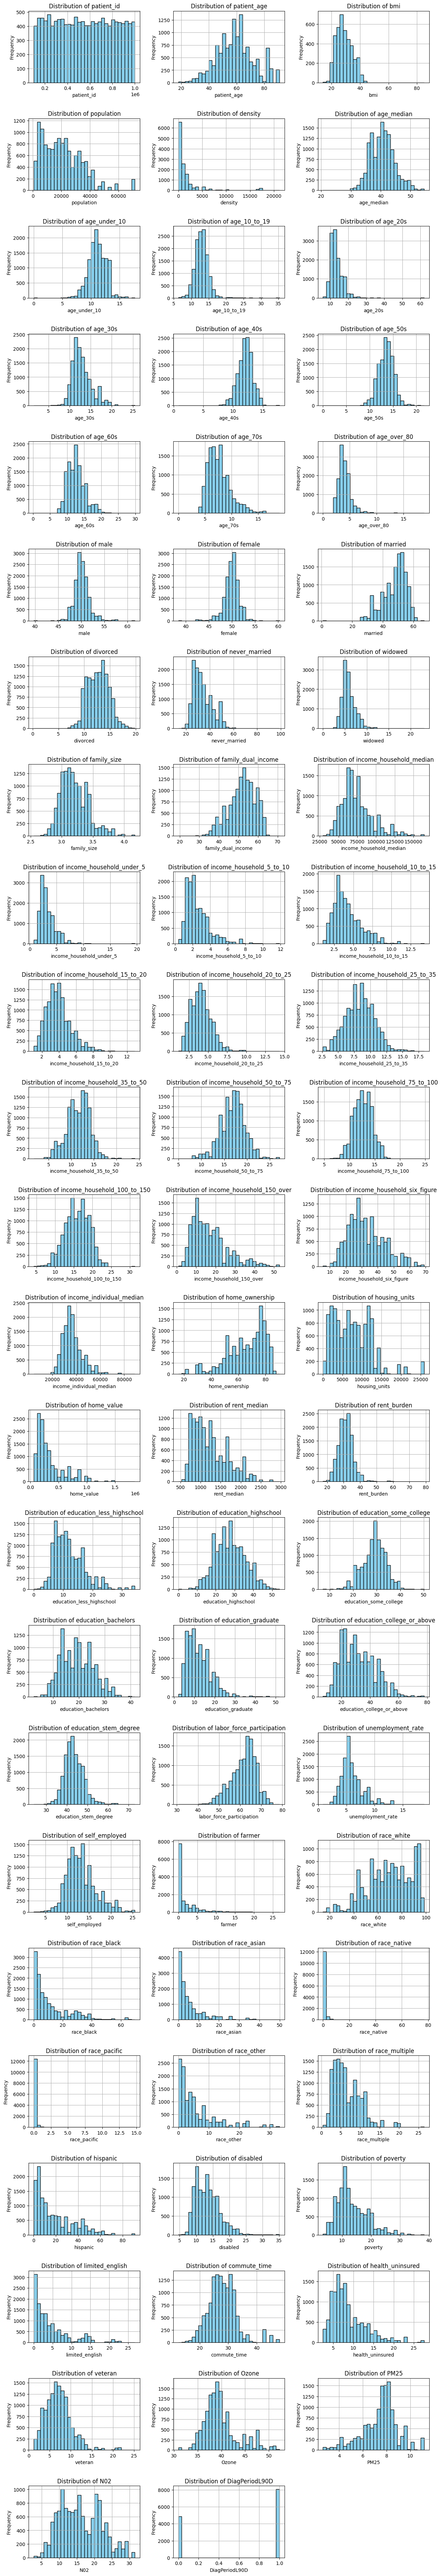

In [9]:
import matplotlib.pyplot as plt

# Converting to pandas data frame for visualization
diagnosis_pandas_df = diagnosis.toPandas()

# Identifying numerical columns in the DataFrame
numerical_columns = diagnosis_pandas_df.select_dtypes(include=['integer', 'double']).columns

# Plotting histograms for each numerical feature
num_plots = len(numerical_columns)
cols = 3  # Define how many columns you want in your subplot grid
rows = (num_plots + cols - 1) // cols  # Calculate required number of rows

fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
fig.subplots_adjust(hspace=0.5, wspace=0.3)

for i, col in enumerate(numerical_columns):
    ax = axs[i//cols, i%cols]  # Locate the position of the subplot
    diagnosis_pandas_df[col].hist(ax=ax, bins=30, color='skyblue', edgecolor='black')
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

# If the number of plots is not a perfect multiple of cols, hide the empty subplots
for j in range(i + 1, rows * cols):
    axs[j//cols, j%cols].axis('off')

plt.show()

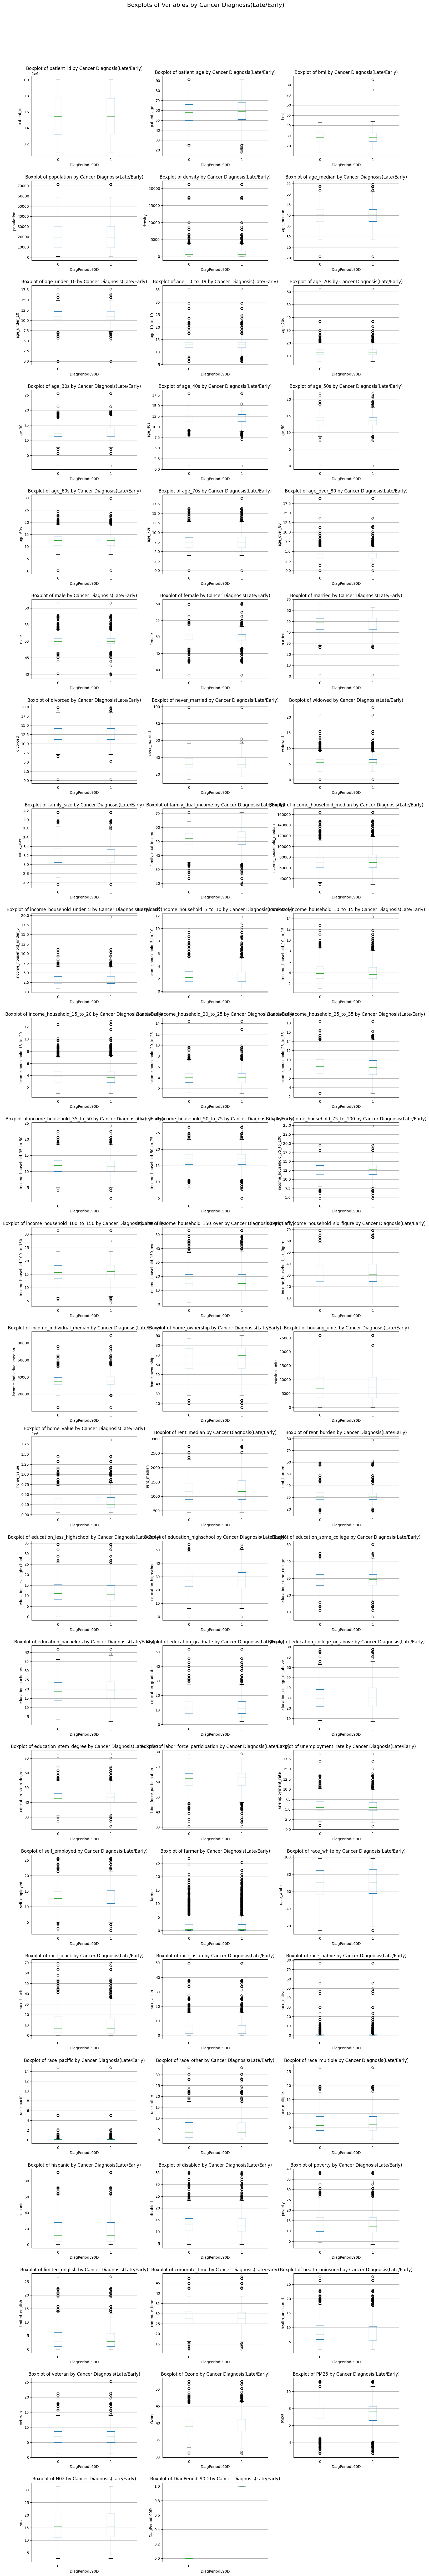

In [10]:
import matplotlib.pyplot as plt

# Identifying numerical columns in the DataFrame
numerical_columns = diagnosis_pandas_df.select_dtypes(include=['integer', 'double']).columns

# Plotting boxplots for each numerical feature, subdivided by 'DiagPeriodL90D'
num_plots = len(numerical_columns)
cols = 3  # Define how many columns you want in your subplot grid
rows = (num_plots + cols - 1) // cols  # Calculate required number of rows

fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
fig.subplots_adjust(hspace=0.5, wspace=0.3)

for i, col in enumerate(numerical_columns):
    ax = axs[i // cols, i % cols]  # Locate the position of the subplot
    # Creating boxplot
    diagnosis_pandas_df.boxplot(column=col, by='DiagPeriodL90D', ax=ax)
    ax.set_title(f'Boxplot of {col} by Cancer Diagnosis(Late/Early)')
    ax.set_xlabel('DiagPeriodL90D')
    ax.set_ylabel(col)

# Set a general title
plt.suptitle('Boxplots of Variables by Cancer Diagnosis(Late/Early)', fontsize=16, y=1.02)

# If the number of plots is not a perfect multiple of cols, hide the empty subplots
for j in range(i + 1, rows * cols):
    axs[j // cols, j % cols].axis('off')

plt.tight_layout()
plt.show()


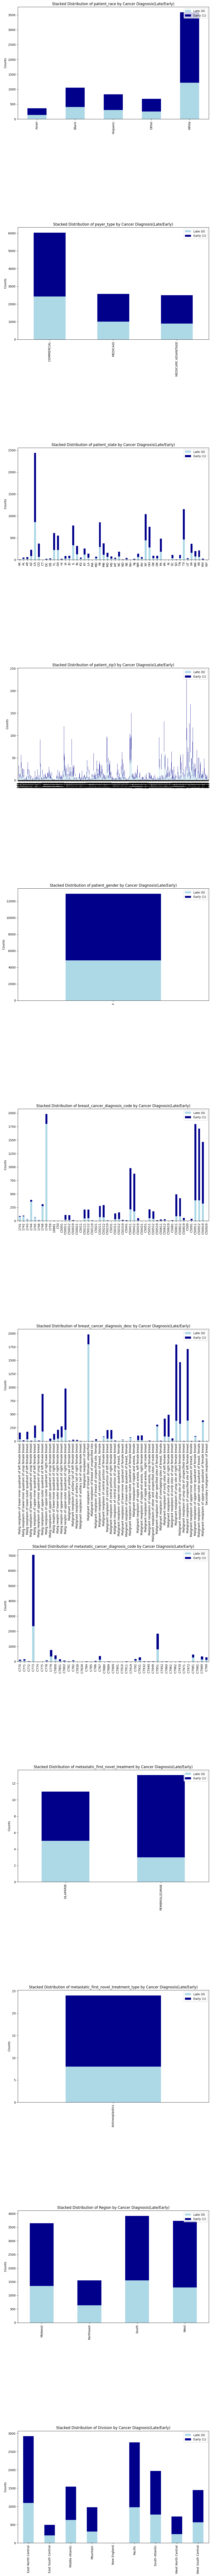

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'diagnosis_pandas_df' is your DataFrame
# Identify categorical columns (assuming 'object' dtype for simplicity; adjust as needed)
categorical_cols = diagnosis_pandas_df.select_dtypes(include=['object']).columns

# Set up the figure size and layout dynamically based on the number of categorical columns
n_rows = len(categorical_cols)  # One row per categorical variable
fig, axes = plt.subplots(n_rows, 1, figsize=(10, 10 * n_rows))  # Increase the height factor here

# If there's only one categorical column, axes might not be an array
if n_rows == 1:
    axes = [axes]

# Create a stacked bar plot for each categorical variable
for i, col in enumerate(categorical_cols):
    # Create a crosstab to get the count of each category for each 'DiagPeriodL90D' value
    data_crosstab = pd.crosstab(diagnosis_pandas_df[col], diagnosis_pandas_df['DiagPeriodL90D'])

    # Plotting the stacked bar plot
    data_crosstab.plot(kind='bar', stacked=True, ax=axes[i], color=['lightblue', 'darkblue'])
    axes[i].set_title(f'Stacked Distribution of {col} by Cancer Diagnosis(Late/Early)')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Counts')
    axes[i].tick_params(axis='x')  # Rotate x-axis labels for better visibility

    # Add legend
    axes[i].legend(['Late (0)', 'Early (1)'], loc='upper right')

# Adjust layout to prevent label overlap
plt.tight_layout()
plt.show()


<ipython-input-12-88fa1b59e0c5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data[col] = pd.to_numeric(plot_data[col], errors='coerce')  # Coerce errors will convert non-numeric values to NaN


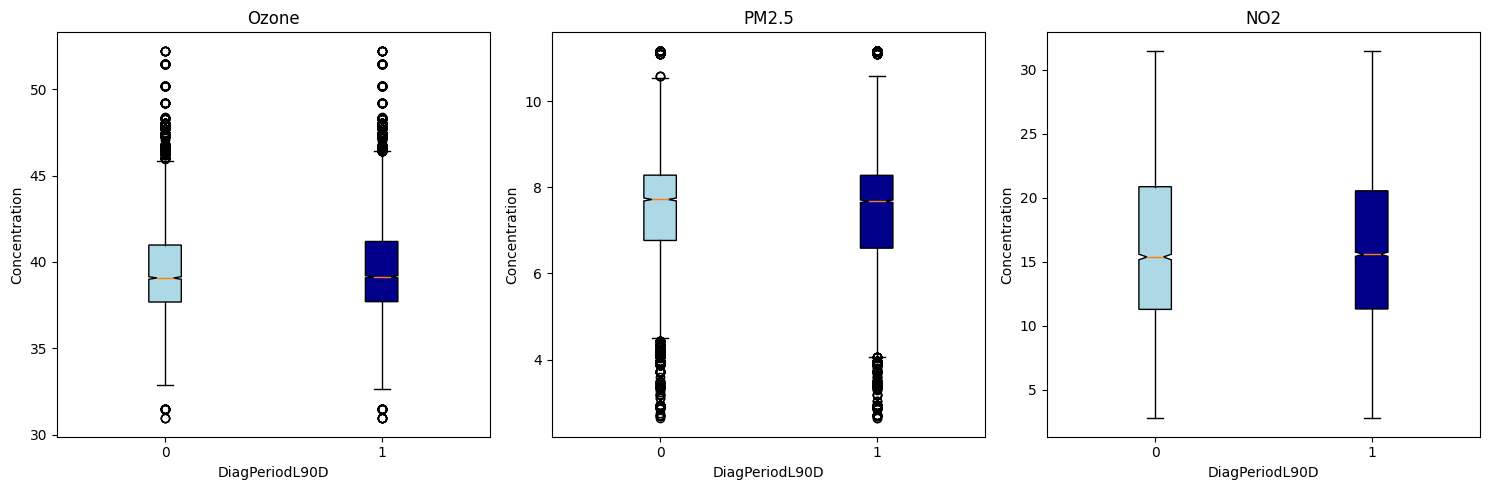

In [12]:
import matplotlib.pyplot as plt
import pandas as pd


# Selecting only the columns needed for the boxplot
columns_of_interest = ['Ozone', 'PM25', 'N02', 'DiagPeriodL90D']

# Filtering the data
plot_data = diagnosis_pandas_df[columns_of_interest]

# Ensure all data are of float type and handle non-numeric issues
for col in ['Ozone', 'PM25', 'N02']:
    plot_data[col] = pd.to_numeric(plot_data[col], errors='coerce')  # Coerce errors will convert non-numeric values to NaN

# Define the colors for the two groups
colors = ['lightblue', 'darkblue']  # lightblue for 0, darkblue for 1

# Create a figure and a set of subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Titles for each subplot
titles = ['Ozone', 'PM2.5', 'NO2']

for i, column in enumerate(['Ozone', 'PM25', 'N02']):
    # Create boxplots for each group
    group0 = plot_data[plot_data['DiagPeriodL90D'] == 0][column]
    group1 = plot_data[plot_data['DiagPeriodL90D'] == 1][column]

    # Boxplot data
    data = [group0.dropna(), group1.dropna()]  # Drop NA values for cleaner boxplots

    # Plotting
    bplot = axs[i].boxplot(data, patch_artist=True, notch=True, labels=['0', '1'])

    # Setting colors for each box in the boxplot
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

    # Set titles and labels
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('DiagPeriodL90D')
    axs[i].set_ylabel('Concentration')

# Adjust layout
plt.tight_layout()
plt.show()


In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by state and DiagPeriodL90D, then count occurrences
state_diagnosis = diagnosis_pandas_df.groupby(['patient_state', 'DiagPeriodL90D']).size().unstack(fill_value=0)


# Compute total diagnoses per state
state_diagnosis['total'] = state_diagnosis.sum(axis=1)

# Calculate percentage of late diagnoses (assuming 1 indicates late)
state_diagnosis['percent_late'] = (state_diagnosis[0] / state_diagnosis['total']) * 100

# Sort states by the percentage of late diagnoses
state_diagnosis = state_diagnosis.sort_values('total', ascending=False)

# Filter states with total diagnoses greater than 100
state_diagnosis_filtered = state_diagnosis[state_diagnosis['total'] > 100]

state_diagnosis_filtered = state_diagnosis_filtered.sort_values('percent_late', ascending=False)

print(state_diagnosis_filtered)

DiagPeriodL90D    0     1  total  percent_late
patient_state                                 
KY              121   138    259     46.718147
VA              159   206    365     43.561644
NM               60    81    141     42.553191
NY              442   599   1041     42.459174
IL              331   451    782     42.327366
NC               78   108    186     41.935484
GA              222   329    551     40.290381
TX              464   691   1155     40.173160
MO               64    96    160     40.000000
IN              123   194    317     38.801262
AZ               87   142    229     37.991266
PA              183   300    483     37.888199
OH              284   470    754     37.665782
WA               75   125    200     37.500000
FL              223   386    609     36.617406
SC               39    71    110     35.454545
CA              862  1576   2438     35.356850
MI              293   565    858     34.149184
TN               38    74    112     33.928571
LA           

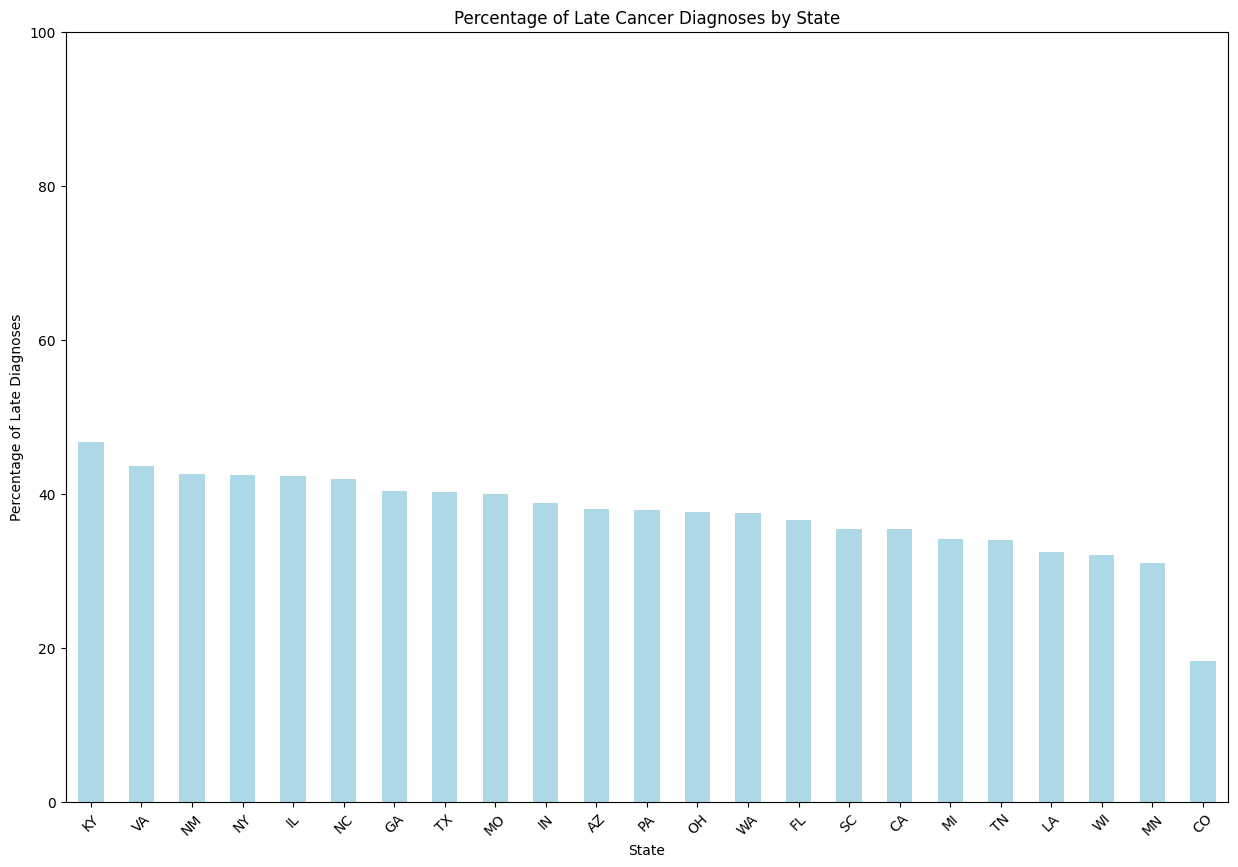

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
state_diagnosis_filtered['percent_late'].plot(kind='bar', color='lightblue')
plt.title('Percentage of Late Cancer Diagnoses by State')
plt.xlabel('State')
plt.xticks(rotation=45)
plt.ylabel('Percentage of Late Diagnoses')
plt.ylim(0, 100)  # Set y-axis limits from 0 to 100
plt.show()


In [15]:
import pandas as pd
import plotly.graph_objects as go

# Assuming state_diagnosis is already computed

# Define the specific states
specific_states = ['KY', 'VA', 'NM', 'NY', 'IL']

# Plotting
fig = go.Figure()

# Add traces for all states
fig.add_trace(go.Choropleth(
    locations=state_diagnosis.index,  # State codes
    z=[0 if state in specific_states else 1 for state in state_diagnosis.index],  # Assign value 0 to specific states, 1 to others
    locationmode='USA-states',  # Set of locations match entries in `locations`
    colorscale=[[0, 'rgb(158, 202, 225)'], [1, 'rgb(49, 130, 189)']],  # Custom color scale: light blue for specific states, medium blue for others
    hoverinfo='none',  # Disable hover info for better visualization
    showscale=False,  # Hide the color scale
    geo='geo',  # Set the geo layout
))

# Update layout
fig.update_layout(
    title_text='US Map with Specific States Colored Light Blue',
    geo=dict(
        scope='usa',
        showland=True,
        landcolor='rgb(217, 217, 217)',
    ),
)

fig.show()


#Feature Engineering

In [16]:
from pyspark.sql.functions import udf, substring
from pyspark.sql.types import StringType
from pyspark.ml import feature, evaluation, Pipeline

In [17]:
# Define the UDF
def check_first_character_udf(s):
    if s[0].isalpha():
        return 'ICD-10'
    elif s[0].isdigit():
        return 'ICD-9'
    else:
        return 'Unknown'

# Register the UDF
check_first_character = udf(check_first_character_udf, StringType())


#df['diagnosis_category'] = df['metastatic_cancer_diagnosis_code'].str[:3]



diagnosis_engineered = diagnosis.withColumn("ICD_version", check_first_character(diagnosis["breast_cancer_diagnosis_code"]))\
.withColumn("diagnosis_category", substring(diagnosis["metastatic_cancer_diagnosis_code"], 1, 3))


In [18]:
diagnosis_engineered.select(["breast_cancer_diagnosis_code","ICD_version", "diagnosis_category", "metastatic_cancer_diagnosis_code"]).show()

+----------------------------+-----------+------------------+--------------------------------+
|breast_cancer_diagnosis_code|ICD_version|diagnosis_category|metastatic_cancer_diagnosis_code|
+----------------------------+-----------+------------------+--------------------------------+
|                      C50919|     ICD-10|               C79|                           C7989|
|                      C50411|     ICD-10|               C77|                            C773|
|                      C50112|     ICD-10|               C77|                            C773|
|                      C50212|     ICD-10|               C77|                            C773|
|                        1749|      ICD-9|               C77|                            C773|
|                        1749|      ICD-9|               C79|                           C7981|
|                      C50912|     ICD-10|               C77|                            C779|
|                      C50512|     ICD-10|        

#Data Cleaning & Preprocessing

In [19]:
#Drop column with high number of missing values + patient_id column
diagnosis_cleaned = diagnosis_engineered.drop("patient_id",'breast_cancer_diagnosis_desc', 'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type')

In [20]:
from pyspark.sql.functions import when, isnan, count, col, monotonically_increasing_id, round

from pyspark.sql.types import IntegerType, FloatType, DoubleType

#numeric variables
numeric_column_names = [column.name for column in diagnosis_cleaned.schema.fields
                        if isinstance(column.dataType, (IntegerType, FloatType, DoubleType))]

#categorical variables
categorical_column_names = [column.name for column in diagnosis_cleaned.schema.fields
                        if isinstance(column.dataType, (StringType))]

#categorical_indexede variables
categorical_column_names_indexed = [ col+'_indexed' for col in categorical_column_names ]

categorical_column_names_indexed

['patient_race_indexed',
 'payer_type_indexed',
 'patient_state_indexed',
 'patient_zip3_indexed',
 'patient_gender_indexed',
 'breast_cancer_diagnosis_code_indexed',
 'metastatic_cancer_diagnosis_code_indexed',
 'Region_indexed',
 'Division_indexed',
 'ICD_version_indexed',
 'diagnosis_category_indexed']

In [21]:
from pyspark.ml.feature import Imputer
from pyspark.ml.feature import StringIndexer


#Indexing for categorical columns

# StringIndexer
indexer_cat = StringIndexer(inputCols =categorical_column_names,
                            outputCols = categorical_column_names_indexed,
                               handleInvalid = 'skip')


#Imputing missing values using median for numerical cols and mode for categorical cols

# Initialize the Imputer
imputer_num = Imputer(
    inputCols= numeric_column_names, #specifying the input column names
    outputCols=numeric_column_names, #specifying the output column names
    strategy="median"                  # or "median" if you want to use the median value
)


imputer_cat = Imputer(
    inputCols= categorical_column_names_indexed, #specifying the input column names
    outputCols=categorical_column_names_indexed, #specifying the output column names
    strategy="mode"                  # or "mode" if you want to use the median value
)


In [22]:
# Divid the dataset into training and testing 80%/20%
training_df, testing_df = diagnosis_cleaned.randomSplit([0.8, 0.2], seed = 1870)

In [23]:
from pyspark.ml import Pipeline

di_pipe = Pipeline(stages=[indexer_cat, imputer_cat, imputer_num])

#Impute the training dataset
diagnosis_imputed_training = di_pipe.fit(training_df).transform(training_df)

#Impute the test dataset with the training data values
diagnosis_imputed_testing = di_pipe.fit(training_df).transform(testing_df)

In [24]:
#Check missing values count
#Before
diagnosis_cleaned.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in diagnosis_cleaned.columns]).show()

#After
diagnosis_imputed_training.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in diagnosis_imputed_training.columns]).show()

diagnosis_imputed_testing.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in diagnosis_imputed_testing.columns]).show()

+------------+----------+-------------+------------+-----------+--------------+----+----------------------------+--------------------------------+------+--------+----------+-------+----------+------------+------------+-------+-------+-------+-------+-------+-------+-----------+----+------+-------+--------+-------------+-------+-----------+------------------+-----------------------+------------------------+------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+--------------------------+---------------------------+-------------------------+---------------------------+------------------------+--------------+-------------+----------+-----------+-----------+-------------------------+--------------------+----------------------+-------------------+------------------+--------------------------+---------------------+-------------------------+-----------------+----------

In [25]:
from pyspark.ml import feature

numeric_column_names.remove('DiagPeriodL90D')


col_features = numeric_column_names + categorical_column_names_indexed
col_features_without_engineering = numeric_column_names + ['patient_race_indexed','payer_type_indexed','patient_state_indexed','patient_zip3_indexed','patient_gender_indexed','breast_cancer_diagnosis_code_indexed','metastatic_cancer_diagnosis_code_indexed','Region_indexed','Division_indexed']

#Combine a given list of columns into a single vector column.
va = feature.VectorAssembler(inputCols = col_features,
                             outputCol = 'features')

va_without_engineering = feature.VectorAssembler(inputCols = col_features_without_engineering,
                             outputCol = 'features')



 #[i for i in diagnosis.columns if i not in col_features]

len(col_features)

80

#Base Models

##General Data Investigation / Without Feature Engineering columns

In [26]:
from pyspark.ml.classification import  GBTClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import  RandomForestClassifier
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import LogisticRegression

In [27]:
# Try "all features" using different algorithms:

# LogisticRegressionModel
# GBTClassifier
# DecisionTreeClassifier
# RandomForestClassifier
# LinearSVC




from pyspark.ml.evaluation import BinaryClassificationEvaluator


# initialize the model
log_reg = LogisticRegression(featuresCol = 'features', labelCol = 'DiagPeriodL90D')
gbt = GBTClassifier(featuresCol = 'features', labelCol = 'DiagPeriodL90D')
dtc = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'DiagPeriodL90D')
rfc =  RandomForestClassifier(featuresCol = 'features', labelCol = 'DiagPeriodL90D', numTrees=100)
svc =  LinearSVC(featuresCol = 'features', labelCol = 'DiagPeriodL90D', maxIter=10, regParam=0.1)


# set up the pipeline
logistic_pipe = Pipeline(stages=[va_without_engineering, log_reg])
gbt_pipeline = Pipeline(stages=[va_without_engineering, gbt])
dtc_pipeline = Pipeline(stages=[va_without_engineering, dtc])
rfc_pipeline = Pipeline(stages=[va_without_engineering, rfc])
svc_pipeline = Pipeline(stages=[va_without_engineering, svc])


# train the model
log_reg_model = logistic_pipe.fit(diagnosis_imputed_training)
gbt_model = gbt_pipeline.fit(diagnosis_imputed_training)
dtc_model = dtc_pipeline.fit(diagnosis_imputed_training)
rfc_model = rfc_pipeline.fit(diagnosis_imputed_training)
svc_model = svc_pipeline.fit(diagnosis_imputed_training)


#transform data
predictions_log = log_reg_model.transform(diagnosis_imputed_testing)
predictions_gbt = gbt_model.transform(diagnosis_imputed_testing)
predictions_dtc = dtc_model.transform(diagnosis_imputed_testing)
predictions_rfc = rfc_model.transform(diagnosis_imputed_testing)
predictions_svc = svc_model.transform(diagnosis_imputed_testing)


#Evaluator /AUC default/ Initialization
evaluator = BinaryClassificationEvaluator(rawPredictionCol = 'rawPrediction',
                                          labelCol = 'DiagPeriodL90D')


roc_auc_log_reg = evaluator.evaluate(predictions_log)
roc_auc_gbt = evaluator.evaluate(predictions_gbt)
roc_auc_dtc = evaluator.evaluate(predictions_dtc)
roc_auc_rfc = evaluator.evaluate(predictions_rfc)
roc_auc_svc = evaluator.evaluate(predictions_svc)


#AUC result
print(f'Test log regression AUC score: {roc_auc_log_reg*100:.2f}%')
print(f'Test  GBT AUC score: {roc_auc_gbt*100:.2f}%')
print(f'Test DTC AUC score: {roc_auc_dtc*100:.2f}%')
print(f'Test RFC AUC score: {roc_auc_rfc*100:.2f}%')
print(f'Test SVC AUC score: {roc_auc_svc*100:.2f}%')

Test log regression AUC score: 56.00%
Test  GBT AUC score: 80.85%
Test DTC AUC score: 77.88%
Test RFC AUC score: 75.47%
Test SVC AUC score: 55.22%


##General Data Investigation / With Feature Engineering columns

In [28]:
# Try "all features" using different algorithms:

# LogisticRegressionModel
# GBTClassifier
# DecisionTreeClassifier
# RandomForestClassifier
# LinearSVC




from pyspark.ml.evaluation import BinaryClassificationEvaluator


# initialize the model
log_reg = LogisticRegression(featuresCol = 'features', labelCol = 'DiagPeriodL90D')
gbt = GBTClassifier(featuresCol = 'features', labelCol = 'DiagPeriodL90D')
dtc = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'DiagPeriodL90D')
rfc =  RandomForestClassifier(featuresCol = 'features', labelCol = 'DiagPeriodL90D', numTrees=100)
svc =  LinearSVC(featuresCol = 'features', labelCol = 'DiagPeriodL90D', maxIter=10, regParam=0.1)


# set up the pipeline
logistic_pipe = Pipeline(stages=[va, log_reg])
gbt_pipeline = Pipeline(stages=[va, gbt])
dtc_pipeline = Pipeline(stages=[va, dtc])
rfc_pipeline = Pipeline(stages=[va, rfc])
svc_pipeline = Pipeline(stages=[va, svc])


# train the model
log_reg_model = logistic_pipe.fit(diagnosis_imputed_training)
gbt_model = gbt_pipeline.fit(diagnosis_imputed_training)
dtc_model = dtc_pipeline.fit(diagnosis_imputed_training)
rfc_model = rfc_pipeline.fit(diagnosis_imputed_training)
svc_model = svc_pipeline.fit(diagnosis_imputed_training)


#transform data
predictions_log = log_reg_model.transform(diagnosis_imputed_testing)
predictions_gbt = gbt_model.transform(diagnosis_imputed_testing)
predictions_dtc = dtc_model.transform(diagnosis_imputed_testing)
predictions_rfc = rfc_model.transform(diagnosis_imputed_testing)
predictions_svc = svc_model.transform(diagnosis_imputed_testing)


#Evaluator /AUC default/ Initialization
evaluator = BinaryClassificationEvaluator(rawPredictionCol = 'rawPrediction',
                                          labelCol = 'DiagPeriodL90D')


roc_auc_log_reg = evaluator.evaluate(predictions_log)
roc_auc_gbt = evaluator.evaluate(predictions_gbt)
roc_auc_dtc = evaluator.evaluate(predictions_dtc)
roc_auc_rfc = evaluator.evaluate(predictions_rfc)
roc_auc_svc = evaluator.evaluate(predictions_svc)


#AUC result
print(f'Test log regression AUC score: {roc_auc_log_reg*100:.2f}%')
print(f'Test  GBT AUC score: {roc_auc_gbt*100:.2f}%')
print(f'Test DTC AUC score: {roc_auc_dtc*100:.2f}%')
print(f'Test RFC AUC score: {roc_auc_rfc*100:.2f}%')
print(f'Test SVC AUC score: {roc_auc_svc*100:.2f}%')

Test log regression AUC score: 79.49%
Test  GBT AUC score: 80.00%
Test DTC AUC score: 77.85%
Test RFC AUC score: 79.93%
Test SVC AUC score: 78.82%


In [29]:
# Get feature importances
importances = rfc_model.stages[-1].featureImportances

# Assuming the feature names are stored in a list that matches the order of features in the VectorAssembler
feature_names = col_features  # This should be the list of feature names used in VectorAssembler

# Zip feature names with their importance scores
feature_importance_list = zip(feature_names, importances)

# Sort features by importance
sorted_features = sorted(feature_importance_list, key=lambda x: x[1], reverse=True)

# Print sorted features and their importances
for feature, importance in sorted_features[:10]:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: ICD_version_indexed, Importance: 0.41387739851269734
Feature: breast_cancer_diagnosis_code_indexed, Importance: 0.28507089910229394
Feature: patient_age, Importance: 0.04227852280795072
Feature: metastatic_cancer_diagnosis_code_indexed, Importance: 0.020106137991563786
Feature: diagnosis_category_indexed, Importance: 0.013997499483926349
Feature: education_less_highschool, Importance: 0.0066512472637321515
Feature: age_40s, Importance: 0.006221675875819667
Feature: married, Importance: 0.0057136758447410025
Feature: bmi, Importance: 0.00537099343984407
Feature: commute_time, Importance: 0.004888789638401699


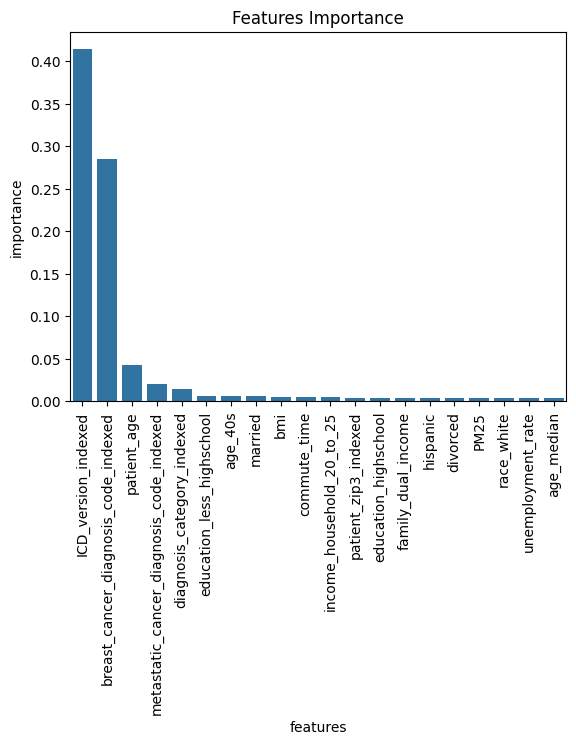

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt


# Extract x and y values from the list of tuples
x_values = [t[0] for t in sorted_features]
y_values = [t[1] for t in sorted_features]

# Create bar plot
sns.barplot(x=x_values[:20], y=y_values[:20])

# Add labels and title
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Features Importance')
plt.xticks(rotation=90)

# Show plot
plt.show()

##Commercial Insurance investigation

In [31]:
commercial_plan= diagnosis_cleaned.filter(diagnosis_cleaned.payer_type == "COMMERCIAL")

In [32]:
training_df, testing_df = commercial_plan.randomSplit([0.8, 0.2], seed = 1870)

In [33]:
from pyspark.ml import Pipeline

di_pipe = Pipeline(stages=[indexer_cat, imputer_cat, imputer_num])

commercial_train_imputed = di_pipe.fit(training_df).transform(training_df)

commercial_test_imputed = di_pipe.fit(training_df).transform(testing_df)

In [34]:
# Try "all features" using different algorithms:

# LogisticRegressionModel
# GBTClassifier
# DecisionTreeClassifier
# RandomForestClassifier



from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator


# initialize the model
log_reg = LogisticRegression(featuresCol = 'features', labelCol = 'DiagPeriodL90D')
gbt = GBTClassifier(featuresCol = 'features', labelCol = 'DiagPeriodL90D')
dtc = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'DiagPeriodL90D')
rfc =  RandomForestClassifier(featuresCol = 'features', labelCol = 'DiagPeriodL90D', numTrees=100)
svc =  LinearSVC(featuresCol = 'features', labelCol = 'DiagPeriodL90D', maxIter=10, regParam=0.1)


# set up the pipeline
logistic_pipe = Pipeline(stages=[va, log_reg])
gbt_pipeline = Pipeline(stages=[va, gbt])
dtc_pipeline = Pipeline(stages=[va, dtc])
rfc_pipeline = Pipeline(stages=[va, rfc])
svc_pipeline = Pipeline(stages=[va, svc])


# train the model
log_reg_model = logistic_pipe.fit(commercial_train_imputed)
gbt_model = gbt_pipeline.fit(commercial_train_imputed)
dtc_model = dtc_pipeline.fit(commercial_train_imputed)
rfc_model = rfc_pipeline.fit(commercial_train_imputed)
svc_model = svc_pipeline.fit(commercial_train_imputed)


#transform data
predictions_log = log_reg_model.transform(commercial_test_imputed)
predictions_gbt = gbt_model.transform(commercial_test_imputed)
predictions_dtc = dtc_model.transform(commercial_test_imputed)
predictions_rfc = rfc_model.transform(commercial_test_imputed)
predictions_svc = svc_model.transform(commercial_test_imputed)


#Evaluator /AUC default/ Initialization
evaluator = BinaryClassificationEvaluator(rawPredictionCol = 'rawPrediction',
                                          labelCol = 'DiagPeriodL90D')


roc_auc_log_reg = evaluator.evaluate(predictions_log)
roc_auc_gbt = evaluator.evaluate(predictions_gbt)
roc_auc_dtc = evaluator.evaluate(predictions_dtc)
roc_auc_rfc = evaluator.evaluate(predictions_rfc)
roc_auc_svc = evaluator.evaluate(predictions_svc)


#AUC result
print(f'Test log regression AUC score: {roc_auc_log_reg*100:.2f}%')
print(f'Test  GBT AUC score: {roc_auc_gbt*100:.2f}%')
print(f'Test DTC AUC score: {roc_auc_dtc*100:.2f}%')
print(f'Test RFC AUC score: {roc_auc_rfc*100:.2f}%')
print(f'Test SVC AUC score: {roc_auc_svc*100:.2f}%')

Test log regression AUC score: 73.83%
Test  GBT AUC score: 72.44%
Test DTC AUC score: 66.62%
Test RFC AUC score: 74.48%
Test SVC AUC score: 71.22%


In [35]:
# Get feature importances
importances = rfc_model.stages[-1].featureImportances

# Assuming the feature names are stored in a list that matches the order of features in the VectorAssembler
feature_names = col_features  # This should be the list of feature names used in VectorAssembler

# Zip feature names with their importance scores
feature_importance_list = zip(feature_names, importances)

# Sort features by importance
sorted_features = sorted(feature_importance_list, key=lambda x: x[1], reverse=True)

# Print sorted features and their importances
for feature, importance in sorted_features[:10]:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: ICD_version_indexed, Importance: 0.352906614707007
Feature: breast_cancer_diagnosis_code_indexed, Importance: 0.2050576756183692
Feature: patient_age, Importance: 0.022767816471817963
Feature: metastatic_cancer_diagnosis_code_indexed, Importance: 0.01671767944585592
Feature: income_individual_median, Importance: 0.01141546575558519
Feature: rent_burden, Importance: 0.009065836714231485
Feature: patient_zip3_indexed, Importance: 0.0090358792809797
Feature: unemployment_rate, Importance: 0.008411072973352224
Feature: income_household_median, Importance: 0.00831066096320402
Feature: diagnosis_category_indexed, Importance: 0.008244201096988594


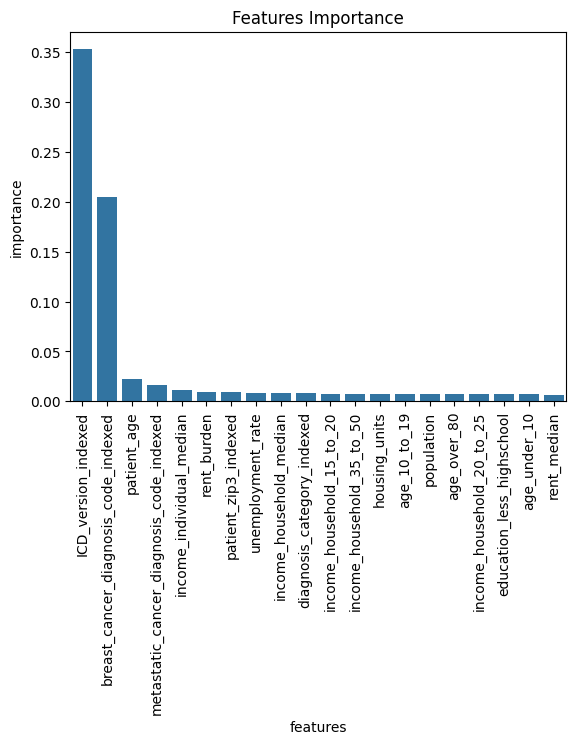

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt


# Extract x and y values from the list of tuples
x_values = [t[0] for t in sorted_features]
y_values = [t[1] for t in sorted_features]

# Create bar plot
sns.barplot(x=x_values[:20], y=y_values[:20])

# Add labels and title
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Features Importance')
plt.xticks(rotation=90)

# Show plot
plt.show()

#Feature Selection

##Univariate Feature Selection

###General

In [37]:
from pyspark.ml.feature import UnivariateFeatureSelector
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

numeric_column_names.append("DiagPeriodL90D")


diagnosis_training_numeric = diagnosis_imputed_training.select(*numeric_column_names)


#diagnosis_training_cat = diagnosis_imputed_training.select(*categorical_column_names_indexed)


va_num = VectorAssembler(inputCols = numeric_column_names,
                             outputCol = 'features')


selector_v1 = UnivariateFeatureSelector(featuresCol="features", outputCol="selectedFeatures",
                                     labelCol="DiagPeriodL90D", selectionMode="fpr")
selector_v1.setFeatureType("continuous").setLabelType("categorical").setSelectionThreshold(0.05)

# pipline
fs_pipeline = Pipeline(stages=[va_num, selector_v1])

#train the model
result_v1_numeric = fs_pipeline.fit(diagnosis_training_numeric).transform(diagnosis_training_numeric)


print("UnivariateFeatureSelector output with top %d features selected using f_classif"
      % selector_v1.getSelectionThreshold())
#result.show()

UnivariateFeatureSelector output with top 0 features selected using f_classif


In [38]:
result_v1_numeric.schema["selectedFeatures"].metadata

{'ml_attr': {'attrs': {'numeric': [{'idx': 0, 'name': 'patient_age'},
    {'idx': 1, 'name': 'education_less_highschool'}]},
  'num_attrs': 2}}

In [39]:
categorical_column_names_indexed.append("DiagPeriodL90D")

diagnosis_training_cat = diagnosis_imputed_training.select(*categorical_column_names_indexed)

va_cat = VectorAssembler(inputCols = categorical_column_names_indexed,
                             outputCol = 'features')


selector_v1 = UnivariateFeatureSelector(featuresCol="features", outputCol="selectedFeatures",
                                     labelCol="DiagPeriodL90D", selectionMode="fpr")
selector_v1.setFeatureType("categorical").setLabelType("categorical").setSelectionThreshold(0.05)

# pipline
fs_pipeline = Pipeline(stages=[va_cat, selector_v1])

#train the model
result_v1_cat = fs_pipeline.fit(diagnosis_training_cat).transform(diagnosis_training_cat)


print("UnivariateFeatureSelector output with top %d features selected using f_classif"
      % selector_v1.getSelectionThreshold())

UnivariateFeatureSelector output with top 0 features selected using f_classif


In [40]:
result_v1_cat.schema["selectedFeatures"].metadata

{'ml_attr': {'attrs': {'numeric': [{'idx': 0,
     'name': 'breast_cancer_diagnosis_code_indexed'},
    {'idx': 1, 'name': 'metastatic_cancer_diagnosis_code_indexed'},
    {'idx': 2, 'name': 'ICD_version_indexed'},
    {'idx': 3, 'name': 'diagnosis_category_indexed'},
    {'idx': 4, 'name': 'DiagPeriodL90D'}]},
  'num_attrs': 5}}

In [41]:
df_training_selected = diagnosis_imputed_training.select(["DiagPeriodL90D", "breast_cancer_diagnosis_code_indexed","metastatic_cancer_diagnosis_code_indexed", "ICD_version_indexed", "diagnosis_category_indexed","patient_age","education_less_highschool" ])

df_testing_selected = diagnosis_imputed_testing.select(["DiagPeriodL90D","breast_cancer_diagnosis_code_indexed","metastatic_cancer_diagnosis_code_indexed", "ICD_version_indexed", "diagnosis_category_indexed","patient_age","education_less_highschool" ])

va_selected = VectorAssembler(inputCols = ["breast_cancer_diagnosis_code_indexed","metastatic_cancer_diagnosis_code_indexed", "ICD_version_indexed", "diagnosis_category_indexed","patient_age","education_less_highschool"],
                             outputCol = 'features')

In [42]:
log_reg = LogisticRegression(featuresCol = 'features', labelCol = 'DiagPeriodL90D')
gbt = GBTClassifier(featuresCol = 'features', labelCol = 'DiagPeriodL90D')
dtc = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'DiagPeriodL90D')
rfc =  RandomForestClassifier(featuresCol = 'features', labelCol = 'DiagPeriodL90D', numTrees=100 )
svc =  LinearSVC(featuresCol = 'features', labelCol = 'DiagPeriodL90D', maxIter=10, regParam=0.1)


# set up the pipeline
logistic_pipe_fs = Pipeline(stages=[va_selected, log_reg])
gbt_pipeline_fs = Pipeline(stages=[va_selected, gbt])
dtc_pipeline_fs = Pipeline(stages=[va_selected, dtc])
rfc_pipeline_fs = Pipeline(stages=[va_selected, rfc])
svc_pipeline_fs = Pipeline(stages=[va_selected, svc])


# train the model
log_reg_model_fs = logistic_pipe_fs.fit(df_training_selected)
gbt_model_fs = gbt_pipeline_fs.fit(df_training_selected)
dtc_model_fs = dtc_pipeline_fs.fit(df_training_selected)
rfc_model_fs = rfc_pipeline_fs.fit(df_training_selected)
svc_model_fs = svc_pipeline_fs.fit(df_training_selected)


#transform data
predictions_log_fs = log_reg_model_fs.transform(df_testing_selected)
predictions_gbt_fs = gbt_model_fs.transform(df_testing_selected)
predictions_dtc_fs = dtc_model_fs.transform(df_testing_selected)
predictions_rfc_fs = rfc_model_fs.transform(df_testing_selected)
predictions_svc_fs = svc_model_fs.transform(df_testing_selected)


#Evaluator /AUC default/ Initialization
evaluator = BinaryClassificationEvaluator(rawPredictionCol = 'rawPrediction',
                                          labelCol = 'DiagPeriodL90D')


roc_auc_log_reg = evaluator.evaluate(predictions_log_fs)
roc_auc_gbt = evaluator.evaluate(predictions_gbt_fs)
roc_auc_dtc = evaluator.evaluate(predictions_dtc_fs)
roc_auc_rfc = evaluator.evaluate(predictions_rfc_fs)
roc_auc_svc = evaluator.evaluate(predictions_svc_fs)


#AUC result
print(f'Test log regression AUC score: {roc_auc_log_reg*100:.2f}%')
print(f'Test  GBT AUC score: {roc_auc_gbt*100:.2f}%')
print(f'Test DTC AUC score: {roc_auc_dtc*100:.2f}%')
print(f'Test RFC AUC score: {roc_auc_rfc*100:.2f}%')
print(f'Test SVC AUC score: {roc_auc_svc*100:.2f}%')

Test log regression AUC score: 80.05%
Test  GBT AUC score: 81.06%
Test DTC AUC score: 77.69%
Test RFC AUC score: 81.35%
Test SVC AUC score: 79.10%


In [43]:
# Get feature importances
importances_fs = rfc_model_fs.stages[-1].featureImportances

# Assuming the feature names are stored in a list that matches the order of features in the VectorAssembler
feature_names = ["breast_cancer_diagnosis_code_indexed","metastatic_cancer_diagnosis_code_indexed", "ICD_version_indexed", "diagnosis_category_indexed","patient_age","education_less_highschool"]  # This should be the list of feature names used in VectorAssembler

# Zip feature names with their importance scores
feature_importance_list_fs = zip(feature_names, importances_fs)

# Sort features by importance
sorted_features_fs = sorted(feature_importance_list_fs, key=lambda x: x[1], reverse=True)
#print(sorted_features_fs[:5])
# Print sorted features and their importances
for feature, importance in sorted_features_fs:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: ICD_version_indexed, Importance: 0.7142304127946075
Feature: breast_cancer_diagnosis_code_indexed, Importance: 0.23225128125928574
Feature: patient_age, Importance: 0.025040228176536446
Feature: metastatic_cancer_diagnosis_code_indexed, Importance: 0.012968624263877356
Feature: education_less_highschool, Importance: 0.011768257663580372
Feature: diagnosis_category_indexed, Importance: 0.0037411958421126024


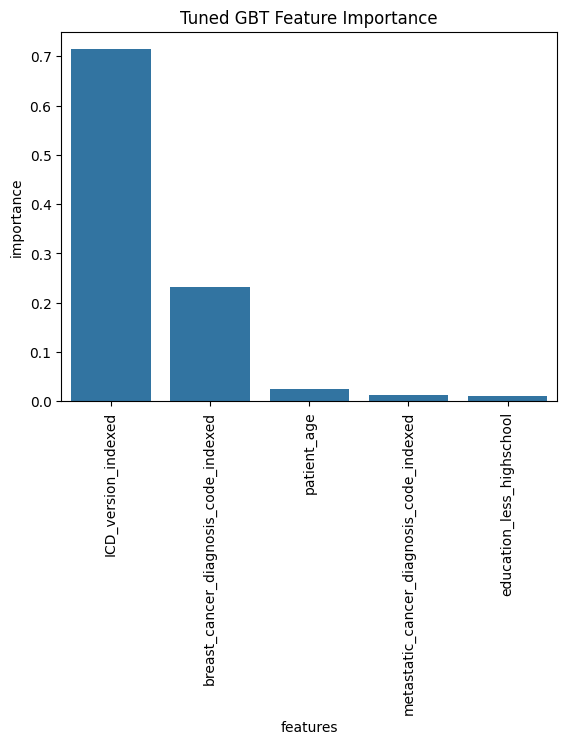

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
plot_features_fs = sorted_features_fs[:5]

# Extract x and y values from the list of tuples
x_values = [t[0] for t in plot_features_fs]
y_values = [t[1] for t in plot_features_fs]

# Create bar plot
sns.barplot(x=x_values[:20], y=y_values[:20])

# Add labels and title
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Tuned GBT Feature Importance')
plt.xticks(rotation=90)

# Show plot
plt.show()

In [45]:
# Get the first tree in the model
tree = rfc_model.stages[-1].trees[0]
print(tree.toDebugString)

DecisionTreeClassificationModel: uid=dtc_6d9fb3b0e256, depth=5, numNodes=45, numClasses=2, numFeatures=80
  If (feature 1 <= 28.985)
   If (feature 37 <= 6654.2027225)
    If (feature 24 <= 2.058322981)
     If (feature 72 <= 282.5)
      If (feature 77 <= 0.5)
       Predict: 0.0
      Else (feature 77 > 0.5)
       Predict: 1.0
     Else (feature 72 > 282.5)
      If (feature 66 <= 38.71030005)
       Predict: 1.0
      Else (feature 66 > 38.71030005)
       Predict: 0.0
    Else (feature 24 > 2.058322981)
     If (feature 59 <= 35.234398035)
      If (feature 57 <= 8.102888222)
       Predict: 1.0
      Else (feature 57 > 8.102888222)
       Predict: 0.0
     Else (feature 59 > 35.234398035)
      If (feature 63 <= 23.108888890000003)
       Predict: 0.0
      Else (feature 63 > 23.108888890000003)
       Predict: 1.0
   Else (feature 37 > 6654.2027225)
    If (feature 78 <= 0.5)
     If (feature 0 <= 71.5)
      Predict: 1.0
     Else (feature 0 > 71.5)
      If (feature 14 <= 50.8

###Commercial

In [46]:
from pyspark.ml.feature import UnivariateFeatureSelector
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

numeric_column_names.append("DiagPeriodL90D")


commercial_train_numeric = commercial_train_imputed.select(*numeric_column_names)


#diagnosis_training_cat = diagnosis_imputed_training.select(*categorical_column_names_indexed)


va_num = VectorAssembler(inputCols = numeric_column_names,
                             outputCol = 'features')


selector_v1 = UnivariateFeatureSelector(featuresCol="features", outputCol="selectedFeatures",
                                     labelCol="DiagPeriodL90D", selectionMode="fpr")
selector_v1.setFeatureType("continuous").setLabelType("categorical").setSelectionThreshold(0.05)

# pipline
fs_pipeline = Pipeline(stages=[va_num, selector_v1])

#train the model
result_v1_numeric = fs_pipeline.fit(commercial_train_numeric).transform(commercial_train_numeric)


print("UnivariateFeatureSelector output with top %d features selected using f_classif"
      % selector_v1.getSelectionThreshold())

UnivariateFeatureSelector output with top 0 features selected using f_classif


In [47]:
result_v1_numeric.schema["selectedFeatures"].metadata

{'ml_attr': {'attrs': {'numeric': [{'idx': 0, 'name': 'patient_age'},
    {'idx': 1, 'name': 'income_household_35_to_50'},
    {'idx': 2, 'name': 'income_household_50_to_75'},
    {'idx': 3, 'name': 'rent_burden'},
    {'idx': 4, 'name': 'education_bachelors'},
    {'idx': 5, 'name': 'education_college_or_above'},
    {'idx': 6, 'name': 'self_employed'}]},
  'num_attrs': 7}}

In [48]:
#categorical_column_names_indexed.append("DiagPeriodL90D")

commercial_train_cat = commercial_train_imputed.select(*categorical_column_names_indexed)

va_cat = VectorAssembler(inputCols = categorical_column_names_indexed,
                             outputCol = 'features')


selector_v1 = UnivariateFeatureSelector(featuresCol="features", outputCol="selectedFeatures",
                                     labelCol="DiagPeriodL90D", selectionMode="fpr")
selector_v1.setFeatureType("categorical").setLabelType("categorical").setSelectionThreshold(0.05)

# pipline
fs_pipeline = Pipeline(stages=[va_cat, selector_v1])

#train the model
result_v1_cat = fs_pipeline.fit(commercial_train_cat).transform(commercial_train_cat)


print("UnivariateFeatureSelector output with top %d features selected using f_classif"
      % selector_v1.getSelectionThreshold())

UnivariateFeatureSelector output with top 0 features selected using f_classif


In [49]:
result_v1_cat.schema["selectedFeatures"].metadata

{'ml_attr': {'attrs': {'numeric': [{'idx': 0, 'name': 'patient_state_indexed'},
    {'idx': 1, 'name': 'breast_cancer_diagnosis_code_indexed'},
    {'idx': 2, 'name': 'metastatic_cancer_diagnosis_code_indexed'},
    {'idx': 3, 'name': 'ICD_version_indexed'},
    {'idx': 4, 'name': 'diagnosis_category_indexed'},
    {'idx': 5, 'name': 'DiagPeriodL90D'}]},
  'num_attrs': 6}}

In [50]:
cdf_training_selected = commercial_train_imputed.select(["DiagPeriodL90D", "patient_age","income_household_50_to_75", "rent_burden", "education_bachelors","self_employed","patient_state_indexed","breast_cancer_diagnosis_code_indexed","metastatic_cancer_diagnosis_code_indexed", "ICD_version_indexed",
                                                        "diagnosis_category_indexed"])

cdf_testing_selected = commercial_test_imputed.select(["DiagPeriodL90D", "patient_age","income_household_50_to_75", "rent_burden", "education_bachelors","self_employed","patient_state_indexed","breast_cancer_diagnosis_code_indexed","metastatic_cancer_diagnosis_code_indexed", "ICD_version_indexed",
                                                        "diagnosis_category_indexed"])
va_selected = VectorAssembler(inputCols = ["patient_age","income_household_50_to_75", "rent_burden", "education_bachelors","self_employed","patient_state_indexed","breast_cancer_diagnosis_code_indexed","metastatic_cancer_diagnosis_code_indexed", "ICD_version_indexed",
                                                        "diagnosis_category_indexed"],
                             outputCol = 'features')

In [51]:
log_reg = LogisticRegression(featuresCol = 'features', labelCol = 'DiagPeriodL90D')
gbt = GBTClassifier(featuresCol = 'features', labelCol = 'DiagPeriodL90D')
dtc = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'DiagPeriodL90D')
rfc =  RandomForestClassifier(featuresCol = 'features', labelCol = 'DiagPeriodL90D', numTrees=100)
svc =  LinearSVC(featuresCol = 'features', labelCol = 'DiagPeriodL90D', maxIter=10, regParam=0.1)


# set up the pipeline
logistic_pipe_fs = Pipeline(stages=[va_selected, log_reg])
gbt_pipeline_fs = Pipeline(stages=[va_selected, gbt])
dtc_pipeline_fs = Pipeline(stages=[va_selected, dtc])
rfc_pipeline_fs = Pipeline(stages=[va_selected, rfc])
svc_pipeline_fs = Pipeline(stages=[va_selected, svc])


# train the model
log_reg_model_fs = logistic_pipe_fs.fit(cdf_training_selected)
gbt_model_fs = gbt_pipeline_fs.fit(cdf_training_selected)
dtc_model_fs = dtc_pipeline_fs.fit(cdf_training_selected)
rfc_model_fs = rfc_pipeline_fs.fit(cdf_training_selected)
svc_model_fs = svc_pipeline_fs.fit(cdf_training_selected)


#transform data
predictions_log_fs = log_reg_model_fs.transform(cdf_testing_selected)
predictions_gbt_fs = gbt_model_fs.transform(cdf_testing_selected)
predictions_dtc_fs = dtc_model_fs.transform(cdf_testing_selected)
predictions_rfc_fs = rfc_model_fs.transform(cdf_testing_selected)
predictions_svc_fs = svc_model_fs.transform(cdf_testing_selected)


#Evaluator /AUC default/ Initialization
evaluator = BinaryClassificationEvaluator(rawPredictionCol = 'rawPrediction',
                                          labelCol = 'DiagPeriodL90D')


roc_auc_log_reg = evaluator.evaluate(predictions_log_fs)
roc_auc_gbt = evaluator.evaluate(predictions_gbt_fs)
roc_auc_dtc = evaluator.evaluate(predictions_dtc_fs)
roc_auc_rfc = evaluator.evaluate(predictions_rfc_fs)
roc_auc_svc = evaluator.evaluate(predictions_svc_fs)


#AUC result
print(f'Test log regression AUC score: {roc_auc_log_reg*100:.2f}%')
print(f'Test  GBT AUC score: {roc_auc_gbt*100:.2f}%')
print(f'Test DTC AUC score: {roc_auc_dtc*100:.2f}%')
print(f'Test RFC AUC score: {roc_auc_rfc*100:.2f}%')
print(f'Test SVC AUC score: {roc_auc_svc*100:.2f}%')

Test log regression AUC score: 72.52%
Test  GBT AUC score: 72.41%
Test DTC AUC score: 67.17%
Test RFC AUC score: 72.38%
Test SVC AUC score: 71.23%


In [52]:
# Get feature importances
importances_fs = gbt_model_fs.stages[-1].featureImportances

# Assuming the feature names are stored in a list that matches the order of features in the VectorAssembler
feature_names = ["patient_age","income_household_50_to_75", "rent_burden", "education_bachelors","self_employed","patient_state_indexed","breast_cancer_diagnosis_code_indexed","metastatic_cancer_diagnosis_code_indexed", "ICD_version_indexed","diagnosis_category_indexed"]  # This should be the list of feature names used in VectorAssembler

# Zip feature names with their importance scores
feature_importance_list_fs = zip(feature_names, importances_fs)

# Sort features by importance
sorted_features_fs = sorted(feature_importance_list_fs, key=lambda x: x[1], reverse=True)
#print(sorted_features_fs[:5])
# Print sorted features and their importances
for feature, importance in sorted_features_fs:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: ICD_version_indexed, Importance: 0.23733841300668274
Feature: patient_age, Importance: 0.18578141092745645
Feature: rent_burden, Importance: 0.12741195166425515
Feature: breast_cancer_diagnosis_code_indexed, Importance: 0.10199882569958658
Feature: income_household_50_to_75, Importance: 0.08652487307710402
Feature: education_bachelors, Importance: 0.0806810692889794
Feature: patient_state_indexed, Importance: 0.065429421937941
Feature: metastatic_cancer_diagnosis_code_indexed, Importance: 0.054365058079172364
Feature: self_employed, Importance: 0.04167620845109004
Feature: diagnosis_category_indexed, Importance: 0.018792767867732287


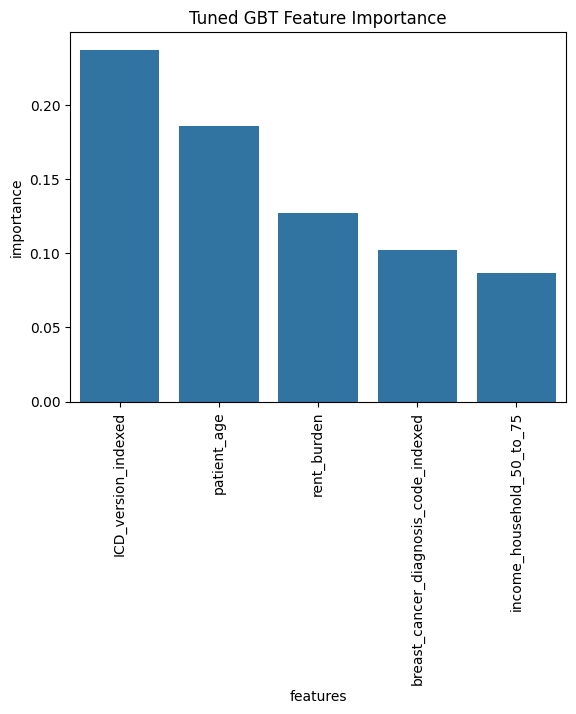

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
plot_features_fs = sorted_features_fs[:5]

# Extract x and y values from the list of tuples
x_values = [t[0] for t in plot_features_fs]
y_values = [t[1] for t in plot_features_fs]

# Create bar plot
sns.barplot(x=x_values[:20], y=y_values[:20])

# Add labels and title
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Tuned GBT Feature Importance')
plt.xticks(rotation=90)

# Show plot
plt.show()

#Varience ThresholdSelector

##General

In [54]:
from pyspark.sql.functions import variance

variance_df = diagnosis_imputed_training.select(*col_features).agg(*(variance(col).alias(col) for col in diagnosis_imputed_training.select(*col_features).columns))

# Show the result
variance_df.show()

+------------------+-----------------+--------------------+-----------------+-----------------+------------------+------------------+------------------+-----------------+------------------+-----------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+-------------------+------------------+-----------------------+------------------------+------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+--------------------------+---------------------------+-------------------------+---------------------------+------------------------+------------------+-------------------+--------------------+-----------------+------------------+-------------------------+--------------------+----------------------+-------------------+------------------+--------------------

In [55]:
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.sql.functions import col, variance, lit


from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

df = diagnosis_imputed_training.select(*col_features)


# UDF for converting column type from vector to double type
unlist = udf(lambda x: float(x[0]), FloatType())

# Iterating over columns to be scaled
for i in col_features:
    # VectorAssembler Transformation - Converting column to vector type
    assembler = VectorAssembler(inputCols=[i],outputCol=i+"_Vect")

    # MinMaxScaler Transformation
    scaler = MinMaxScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")

    # Pipeline of VectorAssembler and MinMaxScaler
    pipeline = Pipeline(stages=[assembler, scaler])

    # Fitting pipeline on dataframe
    df = pipeline.fit(df).transform(df).drop(i+"_Vect").withColumn(i+"_Scaled", unlist(col(i+"_Scaled")))

print("After Scaling :")

After Scaling :


In [56]:
column_names_Scaled = [ col+'_Scaled' for col in col_features ]

variance_df = df.select(column_names_Scaled)

#.agg(*(variance(col).alias(col) for col in column_names_Scaled))

# Show the result
variance_df.show()

+------------------+----------+-----------------+--------------+-----------------+-------------------+-------------------+--------------+--------------+--------------+--------------+--------------+--------------+------------------+-----------+-------------+--------------+---------------+--------------------+--------------+------------------+-------------------------+------------------------------+-------------------------------+-------------------------------+--------------------------------+--------------------------------+--------------------------------+--------------------------------+--------------------------------+--------------------------------+---------------------------------+----------------------------------+--------------------------------+----------------------------------+-------------------------------+---------------------+--------------------+-----------------+------------------+------------------+--------------------------------+---------------------------+---------

In [57]:
test = variance_df.select(*column_names_Scaled).toPandas()

In [58]:
# Sort the Series in descending order
y = test.var(axis=0)
s_desc = y.sort_values(ascending=False)

In [59]:
test.head()

patient_age_Scaled  bmi_Scaled  population_Scaled  density_Scaled  \
0            0.342466    0.462121           0.500697        0.250005   
1            0.589041    0.462121           0.500697        0.250005   
2            0.616438    0.549931           0.500697        0.250005   
3            0.315068    0.300964           0.490741        0.168025   
4            0.493151    0.462121           0.490741        0.168025   

   age_median_Scaled  age_under_10_Scaled  age_10_to_19_Scaled  \
0           0.484157             0.592261             0.170891   
1           0.484157             0.592261             0.170891   
2           0.484157             0.592261             0.170891   
3           0.547331             0.671563             0.260522   
4           0.547331             0.671563             0.260522   

   age_20s_Scaled  age_30s_Scaled  age_40s_Scaled  ...  \
0        0.201315        0.665022        0.722137  ...   
1        0.201315        0.665022        0.722137  ...   
2        0.201315        0.665022        0.722137  ...   
3        0.137288        0.512634        0.757932  ...   
4        0.137288        0.512634        0.757932  ...   

   payer_type_indexed_Scaled  patient_state_indexed_Scaled  \
0                        0.0                           0.0   
1                        0.0                           0.0   
2                        0.0                           0.0   
3                        0.0                           0.0   
4                        0.0                           0.0   

   patient_zip3_indexed_Scaled  patient_gender_indexed_Scaled  \
0                     0.000000                            0.5   
1                     0.000000                            0.5   
2                     0.000000                            0.5   
3                     0.009763                            0.5   
4                     0.009763                            0.5   

   breast_cancer_diagnosis_code_indexed_Scaled  \
0                                     0.065217   
1                                     0.043478   
2                                     0.021739   
3                                     0.108696   
4                                     0.500000   

   metastatic_cancer_diagnosis_code_indexed_Scaled  Region_indexed_Scaled  \
0                                              0.0               0.333333   
1                                              0.0               0.333333   
2                                              0.1               0.333333   
3                                              0.0               0.333333   
4                                              0.0               0.333333   

   Division_indexed_Scaled  ICD_version_indexed_Scaled  \
0                    0.125                         0.0   
1                    0.125                         0.0   
2                    0.125                         0.0   
3                    0.125                         0.0   
4                    0.125                         0.0   

   diagnosis_category_indexed_Scaled  
0                                0.0  
1                                0.0  
2                                1.0  
3                                0.0  
4                                0.0  

[5 rows x 80 columns]

In [60]:
top = s_desc.nlargest(80)

top

ICD_version_indexed_Scaled           0.166557
payer_type_indexed_Scaled            0.154803
diagnosis_category_indexed_Scaled    0.112849
Region_indexed_Scaled                0.111880
patient_race_indexed_Scaled          0.101213
                                       ...   
age_over_80_Scaled                   0.004201
age_20s_Scaled                       0.003550
race_pacific_Scaled                  0.001104
race_native_Scaled                   0.000604
patient_gender_indexed_Scaled        0.000000
Length: 80, dtype: float32

In [61]:
diagnosis_imputed_training.show(5)

+------------+----------+-------------+------------+-----------+--------------+-----+----------------------------+--------------------------------+------+--------+-----------+-----------+-----------+------------+------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-------------+-----------+-----------+------------------+-----------------------+------------------------+------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+--------------------------+---------------------------+-------------------------+---------------------------+------------------------+--------------+-------------+-----------+-----------+-----------+-------------------------+--------------------+----------------------+-------------------+------------------+--------------------------+---------------------

In [62]:
from pyspark.ml.feature import VarianceThresholdSelector
from pyspark.ml.linalg import Vectors


selector = VarianceThresholdSelector(varianceThreshold= 0.0, outputCol="selectedFeatures")

# pipline
fs_pipeline = Pipeline(stages=[va, selector])

#train the model
result = fs_pipeline.fit(diagnosis_imputed_training).transform(diagnosis_imputed_training)


print("Output: Features with variance lower than %f are removed." %
      selector.getVarianceThreshold())
result.show()

Output: Features with variance lower than 0.000000 are removed.
+------------+----------+-------------+------------+-----------+--------------+-----+----------------------------+--------------------------------+------+--------+-----------+-----------+-----------+------------+------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-------------+-----------+-----------+------------------+-----------------------+------------------------+------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+--------------------------+---------------------------+-------------------------+---------------------------+------------------------+--------------+-------------+-----------+-----------+-----------+-------------------------+--------------------+----------------------+-------------------+---

In [63]:
# Divid the dataset into training and testing 80%/20%
training_df, testing_df = result.randomSplit([0.8, 0.2], seed = 1870)

In [64]:
log_reg = LogisticRegression(featuresCol = 'selectedFeatures', labelCol = 'DiagPeriodL90D')
gbt = GBTClassifier(featuresCol = 'selectedFeatures', labelCol = 'DiagPeriodL90D')
dtc = DecisionTreeClassifier(featuresCol = 'selectedFeatures', labelCol = 'DiagPeriodL90D')
rfc =  RandomForestClassifier(featuresCol = 'selectedFeatures', labelCol = 'DiagPeriodL90D')
svc =  LinearSVC(featuresCol = 'selectedFeatures', labelCol = 'DiagPeriodL90D', maxIter=10, regParam=0.1)


# set up the pipeline
logistic_pipe_v = Pipeline(stages=[log_reg])
gbt_pipeline_v = Pipeline(stages=[gbt])
dtc_pipeline_v = Pipeline(stages=[dtc])
rfc_pipeline_v = Pipeline(stages=[rfc])
svc_pipeline_v = Pipeline(stages=[svc])


# train the model
log_reg_model_v = logistic_pipe_v.fit(training_df)
gbt_model_v = gbt_pipeline_v.fit(training_df)
dtc_model_v = dtc_pipeline_v.fit(training_df)
rfc_model_v = rfc_pipeline_v.fit(training_df)
svc_model_v = svc_pipeline_v.fit(training_df)


#transform data
predictions_log_v = log_reg_model_v.transform(testing_df)
predictions_gbt_v = gbt_model_v.transform(testing_df)
predictions_dtc_v = dtc_model_v.transform(testing_df)
predictions_rfc_v = rfc_model_v.transform(testing_df)
predictions_svc_v = svc_model_v.transform(testing_df)


#Evaluator /AUC default/ Initialization
evaluator = BinaryClassificationEvaluator(rawPredictionCol = 'rawPrediction',
                                          labelCol = 'DiagPeriodL90D')


roc_auc_log_reg = evaluator.evaluate(predictions_log_v)
roc_auc_gbt = evaluator.evaluate(predictions_gbt_v)
roc_auc_dtc = evaluator.evaluate(predictions_dtc_v)
roc_auc_rfc = evaluator.evaluate(predictions_rfc_v)
roc_auc_svc = evaluator.evaluate(predictions_svc_v)


#AUC result
print(f'Test log regression AUC score: {roc_auc_log_reg*100:.2f}%')
print(f'Test  GBT AUC score: {roc_auc_gbt*100:.2f}%')
print(f'Test DTC AUC score: {roc_auc_dtc*100:.2f}%')
print(f'Test RFC AUC score: {roc_auc_rfc*100:.2f}%')
print(f'Test SVC AUC score: {roc_auc_svc*100:.2f}%')

Test log regression AUC score: 74.73%
Test  GBT AUC score: 74.87%
Test DTC AUC score: 72.49%
Test RFC AUC score: 73.41%
Test SVC AUC score: 74.07%


##Commercial

In [65]:
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.sql.functions import col, variance, lit


from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

df = commercial_train_imputed.select(*col_features)


# UDF for converting column type from vector to double type
unlist = udf(lambda x: float(x[0]), FloatType())

# Iterating over columns to be scaled
for i in col_features:
    # VectorAssembler Transformation - Converting column to vector type
    assembler = VectorAssembler(inputCols=[i],outputCol=i+"_Vect")

    # MinMaxScaler Transformation
    scaler = MinMaxScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")

    # Pipeline of VectorAssembler and MinMaxScaler
    pipeline = Pipeline(stages=[assembler, scaler])

    # Fitting pipeline on dataframe
    df = pipeline.fit(df).transform(df).drop(i+"_Vect").withColumn(i+"_Scaled", unlist(col(i+"_Scaled")))

print("After Scaling :")

After Scaling :


In [66]:
column_names_Scaled = [ col+'_Scaled' for col in col_features ]

variance_df = df.select(column_names_Scaled)

#.agg(*(variance(col).alias(col) for col in column_names_Scaled))

# Show the result
variance_df.show()

+------------------+----------+-----------------+--------------+-----------------+-------------------+-------------------+--------------+--------------+--------------+--------------+--------------+--------------+------------------+-----------+-------------+--------------+---------------+--------------------+--------------+------------------+-------------------------+------------------------------+-------------------------------+-------------------------------+--------------------------------+--------------------------------+--------------------------------+--------------------------------+--------------------------------+--------------------------------+---------------------------------+----------------------------------+--------------------------------+----------------------------------+-------------------------------+---------------------+--------------------+-----------------+------------------+------------------+--------------------------------+---------------------------+---------

In [67]:
test = variance_df.select(*column_names_Scaled).toPandas()

In [68]:
y = test.var(axis=0)
s_desc = y.sort_values(ascending=False)

In [69]:
test.head()

patient_age_Scaled  bmi_Scaled  population_Scaled  density_Scaled  \
0            0.136986    0.442721           0.020585        0.001511   
1            0.287671    0.442721           0.496565        0.305499   
2            0.342466    0.442721           0.496565        0.305499   
3            0.561644    0.442721           0.496565        0.305499   
4            0.315068    0.268099           0.486527        0.205322   

   age_median_Scaled  age_under_10_Scaled  age_10_to_19_Scaled  \
0           0.548093             0.446128              0.26113   
1           0.279197             0.403347              0.23155   
2           0.279197             0.403347              0.23155   
3           0.279197             0.403347              0.23155   
4           0.367471             0.519391              0.37800   

   age_20s_Scaled  age_30s_Scaled  age_40s_Scaled  ...  \
0        0.169019        0.296120        0.386252  ...   
1        0.365096        0.760165        0.694640  ...   
2        0.365096        0.760165        0.694640  ...   
3        0.365096        0.760165        0.694640  ...   
4        0.248980        0.523800        0.776052  ...   

   payer_type_indexed_Scaled  patient_state_indexed_Scaled  \
0                        0.5                      0.615385   
1                        0.5                      0.000000   
2                        0.5                      0.000000   
3                        0.5                      0.000000   
4                        0.5                      0.000000   

   patient_zip3_indexed_Scaled  patient_gender_indexed_Scaled  \
0                     0.460317                            0.5   
1                     0.030159                            0.5   
2                     0.030159                            0.5   
3                     0.030159                            0.5   
4                     0.015873                            0.5   

   breast_cancer_diagnosis_code_indexed_Scaled  \
0                                     0.024390   
1                                     0.146341   
2                                     0.073171   
3                                     0.000000   
4                                     0.121951   

   metastatic_cancer_diagnosis_code_indexed_Scaled  Region_indexed_Scaled  \
0                                         0.000000               0.000000   
1                                         0.000000               0.666667   
2                                         0.000000               0.666667   
3                                         0.071429               0.666667   
4                                         0.000000               0.666667   

   Division_indexed_Scaled  ICD_version_indexed_Scaled  \
0                 0.285714                         0.0   
1                 0.142857                         0.0   
2                 0.142857                         0.0   
3                 0.142857                         1.0   
4                 0.142857                         0.0   

   diagnosis_category_indexed_Scaled  
0                                0.0  
1                                0.0  
2                                0.0  
3                                0.0  
4                                0.0  

[5 rows x 80 columns]

In [70]:
top = s_desc.nlargest(80)

top

ICD_version_indexed_Scaled           0.167120
Region_indexed_Scaled                0.100771
patient_race_indexed_Scaled          0.094738
diagnosis_category_indexed_Scaled    0.093868
Division_indexed_Scaled              0.074581
                                       ...   
female_Scaled                        0.008317
race_native_Scaled                   0.001996
race_pacific_Scaled                  0.001959
payer_type_indexed_Scaled            0.000000
patient_gender_indexed_Scaled        0.000000
Length: 80, dtype: float32

In [71]:
from pyspark.ml.feature import VarianceThresholdSelector
from pyspark.ml.linalg import Vectors


selector = VarianceThresholdSelector(varianceThreshold= 0.0, outputCol="selectedFeatures")

# pipline
fs_pipeline = Pipeline(stages=[va, selector])

#train the model
result = fs_pipeline.fit(commercial_train_imputed).transform(commercial_train_imputed)


print("Output: Features with variance lower than %f are removed." %
      selector.getVarianceThreshold())
result.show()

Output: Features with variance lower than 0.000000 are removed.
+------------+----------+-------------+------------+-----------+--------------+-----+----------------------------+--------------------------------+------+------------------+-----------+-----------+-----------+------------+------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-------------+-----------+-----------+------------------+-----------------------+------------------------+------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+--------------------------+---------------------------+-------------------------+---------------------------+------------------------+--------------+-------------+-----------+-----------+-----------+-------------------------+--------------------+----------------------+-------------

In [72]:
# Divid the dataset into training and testing 80%/20%
va_training_df, va_testing_df = result.randomSplit([0.8, 0.2], seed = 1870)

In [73]:
# initialize the model

log_reg = LogisticRegression(featuresCol = 'selectedFeatures', labelCol = 'DiagPeriodL90D')
gbt = GBTClassifier(featuresCol = 'selectedFeatures', labelCol = 'DiagPeriodL90D')
dtc = DecisionTreeClassifier(featuresCol = 'selectedFeatures', labelCol = 'DiagPeriodL90D')
rfc =  RandomForestClassifier(featuresCol = 'selectedFeatures', labelCol = 'DiagPeriodL90D')
svc =  LinearSVC(featuresCol = 'selectedFeatures', labelCol = 'DiagPeriodL90D', maxIter=10, regParam=0.1)


# set up the pipeline
logistic_pipe = Pipeline(stages=[log_reg])
gbt_pipeline = Pipeline(stages=[gbt])
dtc_pipeline = Pipeline(stages=[dtc])
rfc_pipeline = Pipeline(stages=[rfc])
svc_pipeline = Pipeline(stages=[svc])


# train the model
log_reg_model = logistic_pipe.fit(va_training_df)
gbt_model = gbt_pipeline.fit(va_training_df)
dtc_model = dtc_pipeline.fit(va_training_df)
rfc_model = rfc_pipeline.fit(va_training_df)
svc_model = svc_pipeline.fit(va_training_df)


#transform data
predictions_log = log_reg_model.transform(va_testing_df)
predictions_gbt = gbt_model.transform(va_testing_df)
predictions_dtc = dtc_model.transform(va_testing_df)
predictions_rfc = rfc_model.transform(va_testing_df)
predictions_svc = svc_model.transform(va_testing_df)


#Evaluator /AUC default/ Initialization
evaluator = BinaryClassificationEvaluator(rawPredictionCol = 'rawPrediction',
                                          labelCol = 'DiagPeriodL90D')


roc_auc_log_reg = evaluator.evaluate(predictions_log)
roc_auc_gbt = evaluator.evaluate(predictions_gbt)
roc_auc_dtc = evaluator.evaluate(predictions_dtc)
roc_auc_rfc = evaluator.evaluate(predictions_rfc)
roc_auc_svc = evaluator.evaluate(predictions_svc)


#AUC result
print(f'Test log regression AUC score: {roc_auc_log_reg*100:.2f}%')
print(f'Test  GBT AUC score: {roc_auc_gbt*100:.2f}%')
print(f'Test DTC AUC score: {roc_auc_dtc*100:.2f}%')
print(f'Test RFC AUC score: {roc_auc_rfc*100:.2f}%')
print(f'Test SVC AUC score: {roc_auc_svc*100:.2f}%')

Test log regression AUC score: 71.80%
Test  GBT AUC score: 72.36%
Test DTC AUC score: 73.45%
Test RFC AUC score: 71.53%
Test SVC AUC score: 73.18%
